In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Author: Drew Rebar<br>
The purpose of this notebook is to predict the superconducting critical temperature, $T_c$, of a material given the<br>
elemental makeup and/or various physical properties.<br>
<br>
Note: The machine learning model in this notebook does not predict the existence of superconductivity in a material.<br>
<br>
Usefulness: This machine learning model would indicate what temperature range to search for initial measurements<br>
of a proposed superconductor.  The model would also be useful as part of a process for designing superconducting<br>
materials for custom applications.<br>
<br>
Data Source: Kam Hamidieh, A data-driven statistical model for predicting the critical temperature of a superconductor,<br>
Computational Materials Science, Volume 154, November 2018, Pages 346-354.<br>
https://arxiv.org/pdf/1803.10260.pdf (paper), https://archive.ics.uci.edu/ml/datasets/Superconductivty+Data (data archive)<br>
<br>Data access: March 30, 2020

<a id="Outline"></a>

# Outline
<ul>
<li><a href="#Import-Packages">Import Packages</a></li>
<li><a href="#Function-Definition">Function Definition</a></li>
<li><a href="#Import-Data">Import Data</a></li>
<li><a href="#Define-Feature-and-Target-Data">Define Feature and Target Data</a></li>
<li><a href="#Extra-Trees-Regression-Modeling">Extra Trees Regression Modeling</a></li>
<li><a href="#Summary">Summary</a></li>
<li><a href="#New-Material-Data-Entry">New Material Data Entry</a></li>
<li><a href="#New-Material-Tc-Prediction">New Material Tc Prediction</a></li>
</ul>

<a id="Import-Packages"></a>

## Import Packages

In [2]:
#The following subsection clears the deprecation warnings for matplotlib. If the plots begin malfunctioning, comment out this subsection 
#in order to view the warnings.
#######################################
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
#######################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import ExtraTreesRegressor
import time
%matplotlib inline

<a id="Function-Definition"></a>

<ul>
<li><a href="#Outline">Outline</a></li>
<li><a href="#Import-Packages">Import Packages</a></li>
</ul>

## Function Definition
<ul>
<li><a href="#Import-Data">Import Data</a></li>
<li><a href="#Define-Feature-and-Target-Data">Define Feature and Target Data</a></li>
<li><a href="#Extra-Trees-Regression-Modeling">Extra Trees Regression Modeling</a></li>
<li><a href="#Summary">Summary</a></li>
<li><a href="#New-Material-Data-Entry">New Material Data Entry</a></li>
<li><a href="#New-Material-Tc-Prediction">New Material Tc Prediction</a></li>
</ul>

In [3]:
#Function used to characterize and plot critical temperature prediction error.

def accuracy(y_test, y_pred, label):
 
    diff = y_pred - y_test
    
    plt.rcParams.update({'font.size': 20})
    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(y_test, diff)
    ax.axis([0, 150,-125,125])
    plt.xlabel('$T_c$ (K)')
    plt.ylabel('$\Delta$$T_c$')
    ax.tick_params(direction='in')
    
    R2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mean = np.mean(diff)
    standev = np.std(diff)
    
    textstr = '\n'.join((
        r'$T_c: R^2=%.2f$' % (R2, ),
        r'$T_c: MSE=%.2f$' % (mse, ),
        r'',
        r'$\overline{\Delta T_c}=%.2f$' % (mean, ),
        r'$\sigma_{\Delta T_c}=%.2f$' % (standev, )))
    
    ax.text(100, 70, textstr, fontsize=14)

    plt.tight_layout()
    plt.savefig(label + ".png",dpi=300, bbox_inches = "tight")
    plt.show()
    
    return standev

<a id="Import-Data"></a>

<ul>
<li><a href="#Outline">Outline</a></li>
<li><a href="#Import-Packages">Import Packages</a></li>
<li><a href="#Function-Definition">Function Definition</a></li>
</ul>

## Import Data
<ul>
<li><a href="#Define-Feature-and-Target-Data">Define Feature and Target Data</a></li>
<li><a href="#Extra-Trees-Regression-Modeling">Extra Trees Regression Modeling</a></li>
<li><a href="#Summary">Summary</a></li>
<li><a href="#New-Material-Data-Entry">New Material Data Entry</a></li>
<li><a href="#New-Material-Tc-Prediction">New Material Tc Prediction</a></li>
</ul>

In [4]:
##Column definitions: https://arxiv.org/pdf/1803.10260.pdf
#Physical properties: atomic mass, first ionization energy, atomic radius, density, electron affinity, fusion heat, thermal conductivity, valence
#Feature extraction: mean, weighted mean, geometric mean, weighted geometric mean, entropy, weighted entropy, range, weighted range, standard deviation, weighted standard deviation

df = pd.read_csv('superconduct\\train.csv')
df_full = df.copy(deep=True)
df_el = pd.read_csv('superconduct\\unique_m.csv')

#Null value cleaning if necessary
if df.isnull().values.any():
    print("train.csv contains null values.")
    df.dropna()
else:
    print("No null values in train.csv")
    
print("DataFrame shape",df.shape)
print()

if df_el.isnull().values.any():
    print("unique_m.csv contains null values.")
    df_el.dropna()
else:
    print("No null values in unique_m.csv")

print("DataFrame shape",df_el.shape)

No null values in train.csv
DataFrame shape (21263, 82)

No null values in unique_m.csv
DataFrame shape (21263, 88)


In [5]:
#list the columns in train.csv
list(df.columns.values)

['number_of_elements',
 'mean_atomic_mass',
 'wtd_mean_atomic_mass',
 'gmean_atomic_mass',
 'wtd_gmean_atomic_mass',
 'entropy_atomic_mass',
 'wtd_entropy_atomic_mass',
 'range_atomic_mass',
 'wtd_range_atomic_mass',
 'std_atomic_mass',
 'wtd_std_atomic_mass',
 'mean_fie',
 'wtd_mean_fie',
 'gmean_fie',
 'wtd_gmean_fie',
 'entropy_fie',
 'wtd_entropy_fie',
 'range_fie',
 'wtd_range_fie',
 'std_fie',
 'wtd_std_fie',
 'mean_atomic_radius',
 'wtd_mean_atomic_radius',
 'gmean_atomic_radius',
 'wtd_gmean_atomic_radius',
 'entropy_atomic_radius',
 'wtd_entropy_atomic_radius',
 'range_atomic_radius',
 'wtd_range_atomic_radius',
 'std_atomic_radius',
 'wtd_std_atomic_radius',
 'mean_Density',
 'wtd_mean_Density',
 'gmean_Density',
 'wtd_gmean_Density',
 'entropy_Density',
 'wtd_entropy_Density',
 'range_Density',
 'wtd_range_Density',
 'std_Density',
 'wtd_std_Density',
 'mean_ElectronAffinity',
 'wtd_mean_ElectronAffinity',
 'gmean_ElectronAffinity',
 'wtd_gmean_ElectronAffinity',
 'entropy_E

In [6]:
#list the columns in unique_m.csv
list(df_el.columns.values)

['H',
 'He',
 'Li',
 'Be',
 'B',
 'C',
 'N',
 'O',
 'F',
 'Ne',
 'Na',
 'Mg',
 'Al',
 'Si',
 'P',
 'S',
 'Cl',
 'Ar',
 'K',
 'Ca',
 'Sc',
 'Ti',
 'V',
 'Cr',
 'Mn',
 'Fe',
 'Co',
 'Ni',
 'Cu',
 'Zn',
 'Ga',
 'Ge',
 'As',
 'Se',
 'Br',
 'Kr',
 'Rb',
 'Sr',
 'Y',
 'Zr',
 'Nb',
 'Mo',
 'Tc',
 'Ru',
 'Rh',
 'Pd',
 'Ag',
 'Cd',
 'In',
 'Sn',
 'Sb',
 'Te',
 'I',
 'Xe',
 'Cs',
 'Ba',
 'La',
 'Ce',
 'Pr',
 'Nd',
 'Pm',
 'Sm',
 'Eu',
 'Gd',
 'Tb',
 'Dy',
 'Ho',
 'Er',
 'Tm',
 'Yb',
 'Lu',
 'Hf',
 'Ta',
 'W',
 'Re',
 'Os',
 'Ir',
 'Pt',
 'Au',
 'Hg',
 'Tl',
 'Pb',
 'Bi',
 'Po',
 'At',
 'Rn',
 'critical_temp',
 'material']

<a id="Define-Feature-and-Target-Data"></a>

<ul>
<li><a href="#Outline">Outline</a></li>
<li><a href="#Import-Packages">Import Packages</a></li>
<li><a href="#Function-Definition">Function Definition</a></li>
<li><a href="#Import-Data">Import Data</a></li>
</ul>

## Define Feature and Target Data
<ul>
<li><a href="#Extra-Trees-Regression-Modeling">Extra Trees Regression Modeling</a></li>
<li><a href="#Summary">Summary</a></li>
<li><a href="#New-Material-Data-Entry">New Material Data Entry</a></li>
<li><a href="#New-Material-Tc-Prediction">New Material Tc Prediction</a></li>
</ul>

In [7]:
#Data Separation
wtd_gmean_columns = [col for col in df.columns if 'wtd_gmean' in col]
df_wtd_gmean = pd.DataFrame([df.pop(x) for x in wtd_gmean_columns]).T

gmean_columns = [col for col in df.columns if 'gmean' in col]
df_gmean = pd.DataFrame([df.pop(x) for x in gmean_columns]).T

wtd_mean_columns = [col for col in df.columns if 'wtd_mean' in col]
df_wtd_mean = pd.DataFrame([df.pop(x) for x in wtd_mean_columns]).T

mean_columns = [col for col in df.columns if 'mean' in col]
df_mean = pd.DataFrame([df.pop(x) for x in mean_columns]).T

wtd_entropy_columns = [col for col in df.columns if 'wtd_entropy' in col]
df_wtd_entropy = pd.DataFrame([df.pop(x) for x in wtd_entropy_columns]).T

entropy_columns = [col for col in df.columns if 'entropy' in col]
df_entropy = pd.DataFrame([df.pop(x) for x in entropy_columns]).T

wtd_range_columns = [col for col in df.columns if 'wtd_range' in col]
df_wtd_range = pd.DataFrame([df.pop(x) for x in wtd_range_columns]).T

range_columns = [col for col in df.columns if 'range' in col]
df_range = pd.DataFrame([df.pop(x) for x in range_columns]).T

wtd_std_columns = [col for col in df.columns if 'wtd_std' in col]
df_wtd_std = pd.DataFrame([df.pop(x) for x in wtd_std_columns]).T

std_columns = [col for col in df.columns if 'std' in col]
df_std = pd.DataFrame([df.pop(x) for x in std_columns]).T

In [8]:
#Published list of the 20 top features based on XGBoost gain
feature_list = [
    'range_ThermalConductivity',
    'wtd_std_ThermalConductivity',
    'range_atomic_radius',
    'wtd_gmean_ThermalConductivity',
    'std_ThermalConductivity',
    'wtd_entropy_Valence',
    'wtd_std_ElectronAffinity',
    'wtd_entropy_atomic_mass',
    'wtd_mean_Valence',
    'wtd_gmean_ElectronAffinity',
    'wtd_range_ElectronAffinity',
    'wtd_mean_ThermalConductivity',
    'wtd_gmean_Valence',
    'std_atomic_mass',
    'std_Density',
    'wtd_entropy_ThermalConductivity',
    'wtd_range_ThermalConductivity',
    'wtd_mean_atomic_mass',
    'wtd_std_atomic_mass',
    'gmean_Density'
]

In [9]:
#Assigning features and targets
features = {}
target = df.critical_temp

features['wtd_gmean'] = df_wtd_gmean
features['gmean'] = df_gmean
features['wtd_mean'] = df_wtd_mean
features['mean'] = df_mean
features['wtd_entropy'] = df_wtd_entropy
features['entropy'] = df_entropy
features['wtd_range'] = df_wtd_range
features['range'] = df_range
features['wtd_std'] = df_wtd_std
features['std'] = df_std
features['all'] = pd.DataFrame(df_full, columns=[item for item in df_full.columns if item != 'critical_temp'])

features['elem'] = df_el
features['elem'].pop('material')
features['elem'].pop('critical_temp')

features['pub20'] = df_full[feature_list]
print()

<a id="Extra-Trees-Regression-Modeling"></a>

<ul>
<li><a href="#Outline">Outline</a></li>
<li><a href="#Import-Packages">Import Packages</a></li>
<li><a href="#Function-Definition">Function Definition</a></li>
<li><a href="#Import-Data">Import Data</a></li>
<li><a href="#Define-Feature-and-Target-Data">Define Feature and Target Data</a></li>
</ul>

## Extra Trees Regression Modeling
<ul>
<li><a href="#Summary">Summary</a></li>
<li><a href="#New-Material-Data-Entry">New Material Data Entry</a></li>
<li><a href="#New-Material-Tc-Prediction">New Material Tc Prediction</a></li>
</ul>

wtd_gmean features
time = 0.7179772853851318
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                    oob_score=False, random_state=7, verbose=0,
                    warm_start=False)


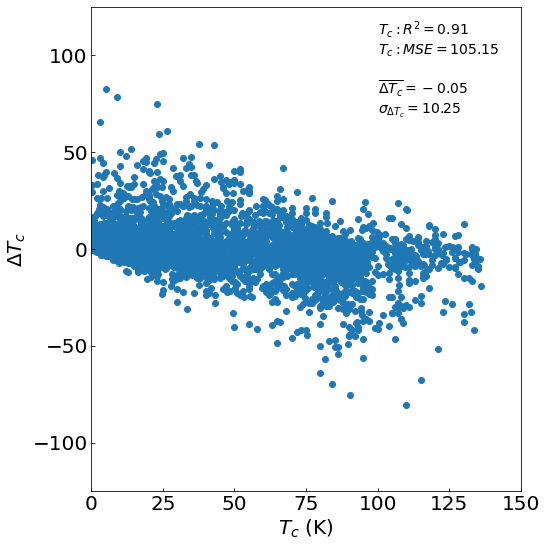

gmean features
time = 0.46575427055358887
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                    oob_score=False, random_state=7, verbose=0,
                    warm_start=False)


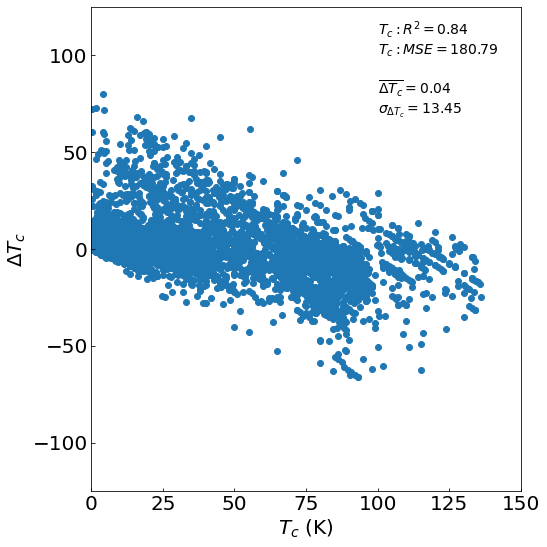

wtd_mean features
time = 0.6440658569335938
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                    oob_score=False, random_state=7, verbose=0,
                    warm_start=False)


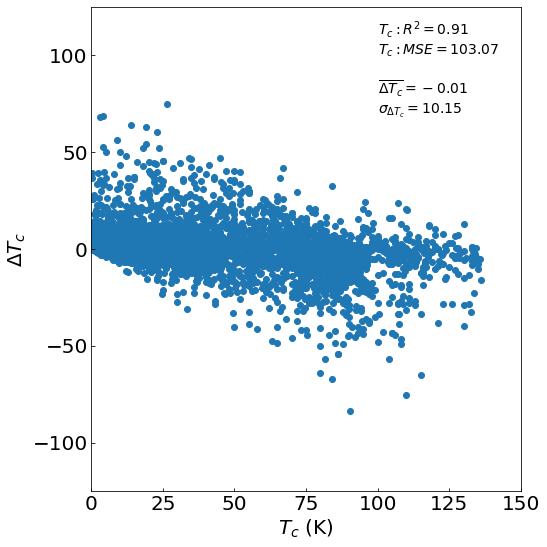

mean features
time = 0.5039901733398438
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                    oob_score=False, random_state=7, verbose=0,
                    warm_start=False)


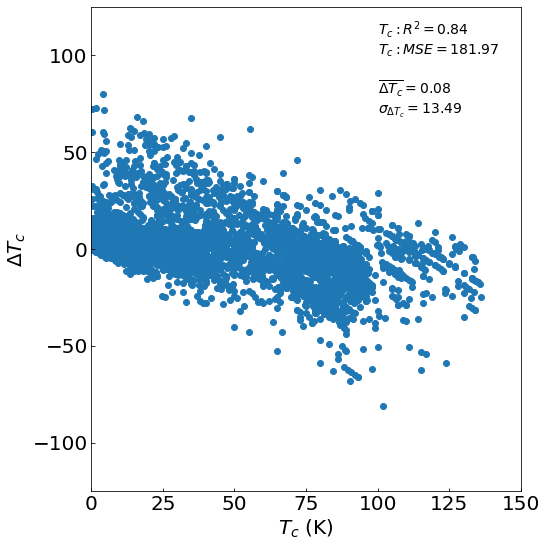

wtd_entropy features
time = 0.714043140411377
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                    oob_score=False, random_state=7, verbose=0,
                    warm_start=False)


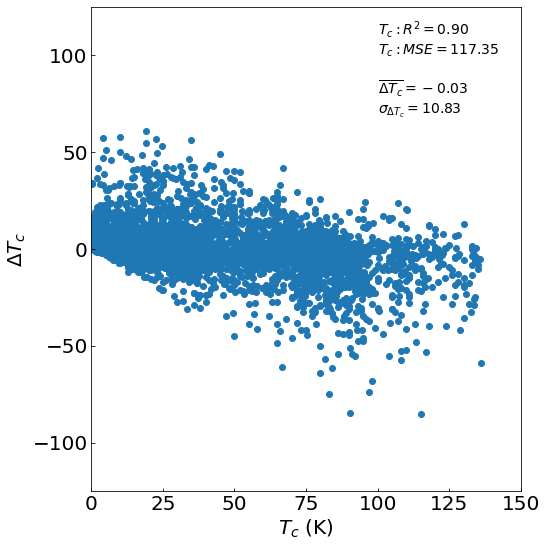

entropy features
time = 0.4863274097442627
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                    oob_score=False, random_state=7, verbose=0,
                    warm_start=False)


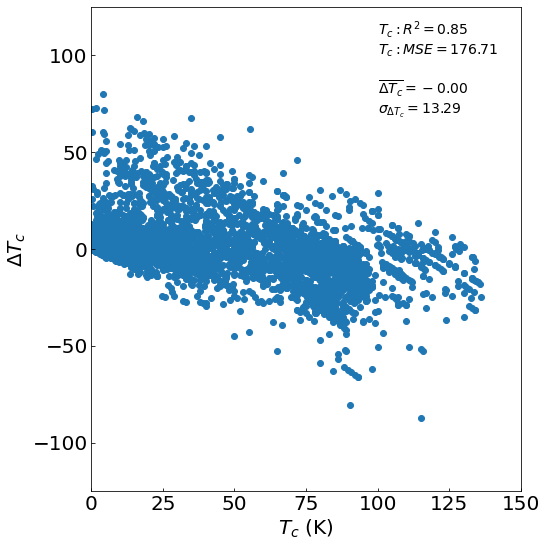

wtd_range features
time = 0.6416025161743164
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                    oob_score=False, random_state=7, verbose=0,
                    warm_start=False)


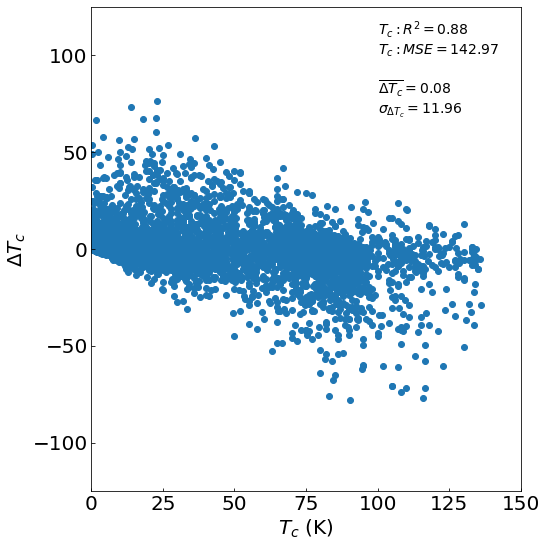

range features
time = 0.47294139862060547
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                    oob_score=False, random_state=7, verbose=0,
                    warm_start=False)


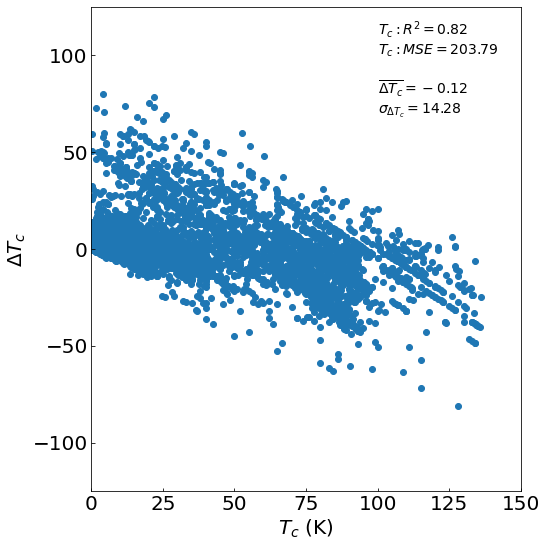

wtd_std features
time = 0.7541627883911133
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                    oob_score=False, random_state=7, verbose=0,
                    warm_start=False)


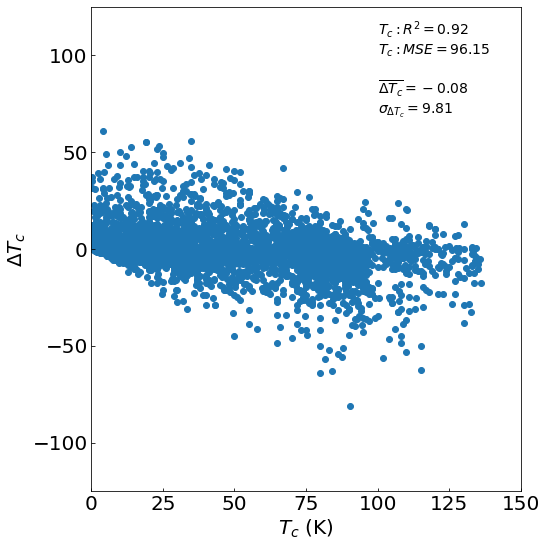

std features
time = 0.5031938552856445
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                    oob_score=False, random_state=7, verbose=0,
                    warm_start=False)


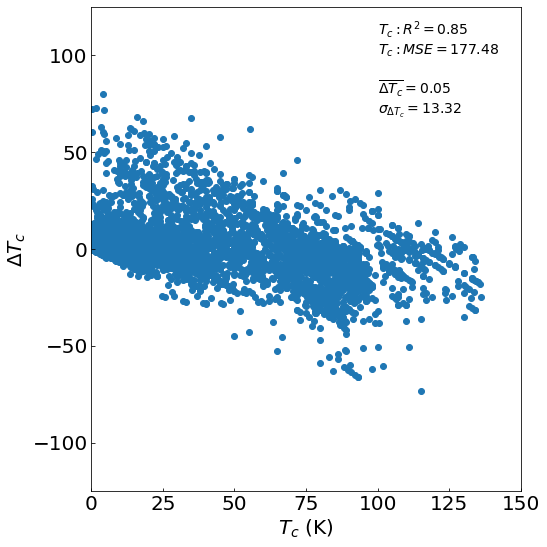

all features
time = 3.5099191665649414
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                    oob_score=False, random_state=7, verbose=0,
                    warm_start=False)


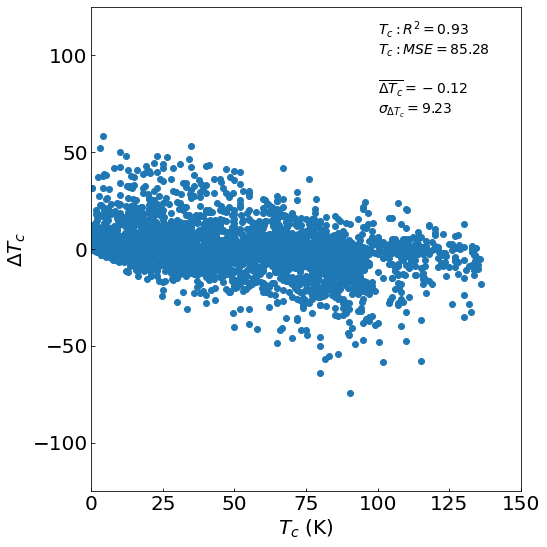

elem features
time = 2.6622211933135986
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                    oob_score=False, random_state=7, verbose=0,
                    warm_start=False)


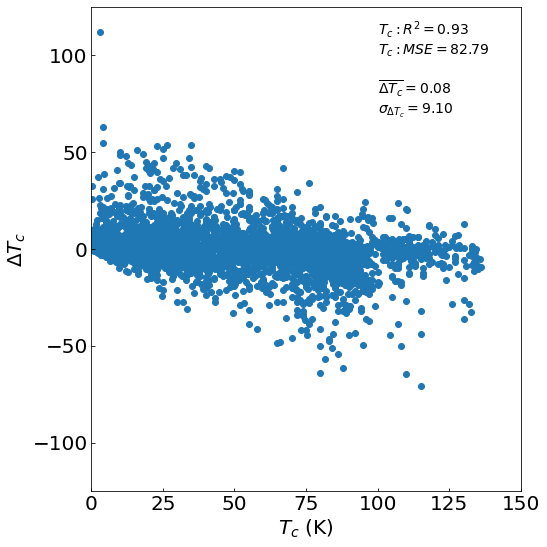

pub20 features
time = 1.0979828834533691
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                    oob_score=False, random_state=7, verbose=0,
                    warm_start=False)


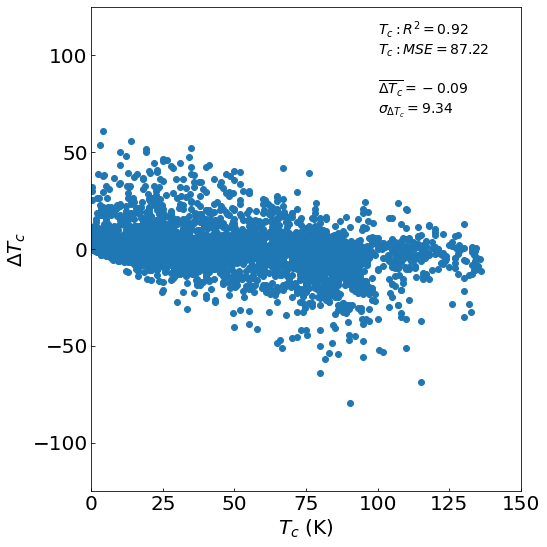

top20 features
time = 1.1339712142944336
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                    oob_score=False, random_state=7, verbose=0,
                    warm_start=False)


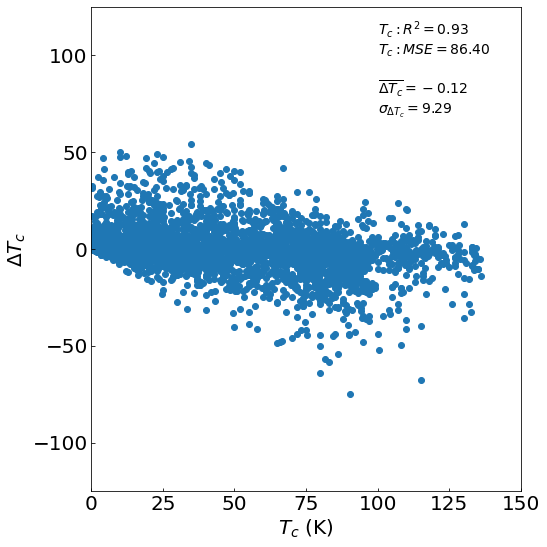

In [10]:
#Define and fit the Extra Trees Regression Models

models = {}
stdev = {}

for x in features:
    #Assign train and test data
    features_train, features_test, target_train, target_test = train_test_split(features[x], target, random_state=11, test_size=0.3)

    t0 = time.time()
    #model selection
    models[x] = ExtraTreesRegressor(n_jobs=-1, n_estimators=70, random_state=7)

    #Fitting the model with the training data
    models[x].fit(features_train, target_train)

    #Determination of predictions from the test data
    target_prediction = models[x].predict(features_test)
    
    t1 = time.time()
    print(x, 'features')
    print('time =', t1-t0)
    print(models[x])

    #Comparision of the predictions to the actual values
    stdev[x] = accuracy(target_test, target_prediction, 'del_Tc_' + x)

    
    
#Top twenty features from the Extra Trees Regression Model
x = 'top20'
top_twenty = sorted(zip(models['all'].feature_importances_, features['all'].columns), key=lambda x: x[0])[-20:]
top_twenty.reverse()
features[x] = pd.DataFrame(df_full, columns=[feature[1] for feature in top_twenty])

#Assign train and test data
features_train, features_test, target_train, target_test = train_test_split(features[x], target, random_state=11, test_size=0.3)

t0 = time.time()
#model selection
models[x] = ExtraTreesRegressor(n_jobs=-1, n_estimators=70, random_state=7)

#Fitting the model with the training data
models[x].fit(features_train, target_train)

#Determination of predictions from the test data
target_prediction = models[x].predict(features_test)

t1 = time.time()
print(x, 'features')
print('time =', t1-t0)
print(models[x])

#Comparision of the predictions to the actual values
stdev[x] = accuracy(target_test, target_prediction, 'del_Tc_' + x)


<a id="Summary"></a><!--Notebook author: Drew Rebar-->

<ul>
<li><a href="#Outline">Outline</a></li>
<li><a href="#Import-Packages">Import Packages</a></li>
<li><a href="#Function-Definition">Function Definition</a></li>
<li><a href="#Import-Data">Import Data</a></li>
<li><a href="#Define-Feature-and-Target-Data">Define Feature and Target Data</a></li>
<li><a href="#Extra-Trees-Regression-Modeling">Extra Trees Regression Modeling</a></li>
</ul>

## Summary
<ul>
<li><a href="#New-Material-Data-Entry">New Material Data Entry</a></li>
<li><a href="#New-Material-Tc-Prediction">New Material Tc Prediction</a></li>
</ul>

In [11]:
#Extra Trees Regression Modeling Summary

print('Expected Tc prediction ranges')

summary = pd.DataFrame(columns=['Features', 'T$_c$ Range'])


for y in features:
    summary = summary.append(pd.DataFrame([[y, '$\displaystyle\pm $' + str(round(stdev[y],1)) + 'K']], columns=['Features', 'T$_c$ Range']), ignore_index=True)

summary.style.hide_index()
display(summary)

print('Published Tc prediction range (XGBoost model): +/- 9.5 K from from Hamidieh, A Data-Driven Statistical Model for Predicting the Critical Temperature of a Superconductor')
print('https://arxiv.org/pdf/1803.10260.pdf')

Expected Tc prediction ranges


,Features,T$_c$ Range
0,wtd_gmean,$\displaystyle\pm $10.3K
1,gmean,$\displaystyle\pm $13.4K
2,wtd_mean,$\displaystyle\pm $10.2K
3,mean,$\displaystyle\pm $13.5K
4,wtd_entropy,$\displaystyle\pm $10.8K
5,entropy,$\displaystyle\pm $13.3K
6,wtd_range,$\displaystyle\pm $12.0K
7,range,$\displaystyle\pm $14.3K
8,wtd_std,$\displaystyle\pm $9.8K
9,std,$\displaystyle\pm $13.3K


Published Tc prediction range (XGBoost model): +/- 9.5 K from from Hamidieh, A Data-Driven Statistical Model for Predicting the Critical Temperature of a Superconductor
https://arxiv.org/pdf/1803.10260.pdf


In [12]:
#Comparison of the top 20 features from the published XGBoost model and the Extra Trees Regression model used in this notebook

t = set(features['top20'].columns)
p = set(features['pub20'].columns)

c = t & p
r = (t ^ p) & t
b = (t ^ p) & p

feature_analysis_dict = {'XGBoost top 20 features': features['pub20'].columns, 'ExtraTreesRegressor top 20 features': features['top20'].columns, 
                         'Common features': list(c), 'XGBoost exclusive features': list(b), 'ExtraTreesRegressor exclusive features': list(r)}

feature_analysis = pd.DataFrame.from_dict( {key:pd.Series(value) for key, value in feature_analysis_dict.items()} )
feature_analysis = feature_analysis.fillna(value='')
feature_analysis.index += 1
feature_analysis

,XGBoost top 20 features,ExtraTreesRegressor top 20 features,Common features,XGBoost exclusive features,ExtraTreesRegressor exclusive features
1,range_ThermalConductivity,range_ThermalConductivity,wtd_std_ElectronAffinity,wtd_gmean_ThermalConductivity,wtd_std_fie
2,wtd_std_ThermalConductivity,wtd_std_ThermalConductivity,wtd_range_ElectronAffinity,gmean_Density,range_fie
3,range_atomic_radius,std_ThermalConductivity,range_atomic_radius,wtd_std_atomic_mass,range_atomic_mass
4,wtd_gmean_ThermalConductivity,range_atomic_radius,wtd_gmean_ElectronAffinity,wtd_range_ThermalConductivity,wtd_entropy_atomic_radius
5,std_ThermalConductivity,range_fie,std_ThermalConductivity,std_Density,gmean_ElectronAffinity
6,wtd_entropy_Valence,wtd_mean_Valence,wtd_entropy_ThermalConductivity,wtd_mean_atomic_mass,wtd_std_Valence
7,wtd_std_ElectronAffinity,wtd_entropy_Valence,wtd_entropy_atomic_mass,,
8,wtd_entropy_atomic_mass,wtd_entropy_atomic_mass,wtd_entropy_Valence,,
9,wtd_mean_Valence,wtd_gmean_ElectronAffinity,wtd_gmean_Valence,,
10,wtd_gmean_ElectronAffinity,wtd_entropy_atomic_radius,std_atomic_mass,,


<a id="New-Material-Data-Entry"></a>

<ul>
<li><a href="#Outline">Outline</a></li>
<li><a href="#Import-Packages">Import Packages</a></li>
<li><a href="#Function-Definition">Function Definition</a></li>
<li><a href="#Import-Data">Import Data</a></li>
<li><a href="#Define-Feature-and-Target-Data">Define Feature and Target Data</a></li>
<li><a href="#Extra-Trees-Regression-Modeling">Extra Trees Regression Modeling</a></li>
<li><a href="#Summary">Summary</a></li>
</ul>

## New Material Data Entry
<ul>
<li><a href="#New-Material-Tc-Prediction">New Material Tc Prediction</a></li>
</ul>

In [13]:
##Predict Tc for a specific material

#Enter new material physical properties and elemental makeup into these dictionaries
#Note: This example data was taken from the training data set (index 13) and is not new data 

#Ba0.1La1.9Ag0.1Cu0.9O4
data_dict = {
    'number_of_elements' :5,
    
    'mean_atomic_mass' :92.729214,
    'mean_fie' :766.44,
    'mean_atomic_radius' :161.2,
    'mean_Density' :5821.4858,
    'mean_ElectronAffinity' :90.89,
    'mean_FusionHeat' :7.7844,
    'mean_ThermalConductivity' :172.205316,
    'mean_Valence' :2.,
    
    'wtd_mean_atomic_mass' :58.51841614,
    'wtd_mean_fie' :1010.61285714,
    'wtd_mean_atomic_radius' :104.97142857,
    'wtd_mean_Density' :3021.01657143,
    'wtd_mean_ElectronAffinity' :112.31642857,
    'wtd_mean_FusionHeat' :3.79685714,
    'wtd_mean_ThermalConductivity' :61.37233143,
    'wtd_mean_Valence' :2.25714286,
    
    'gmean_atomic_mass' :73.13278722,
    'gmean_fie' :720.60551051,
    'gmean_atomic_radius' :141.46521478,
    'gmean_Density' :1237.09508034,
    'gmean_ElectronAffinity' :69.83331461,
    'gmean_FusionHeat' :4.4037905,
    'gmean_ThermalConductivity' :16.06422788,
    'gmean_Valence' :1.88817502,
    
    'wtd_gmean_atomic_mass' :36.39660203,
    'wtd_gmean_fie' :938.74541253,
    'wtd_gmean_atomic_radius' :84.37016696,
    'wtd_gmean_Density' :54.09571826,
    'wtd_gmean_ElectronAffinity' :101.16639774,
    'wtd_gmean_FusionHeat' :1.03525112,
    'wtd_gmean_ThermalConductivity' :0.61973463,
    'wtd_gmean_Valence' :2.21067941,
    
    'entropy_atomic_mass' :1.44930919,
    'entropy_fie' :1.54414454,
    'entropy_atomic_radius' :1.50832754,
    'entropy_Density' :1.31444218,
    'entropy_ElectronAffinity' :1.42799655,
    'entropy_FusionHeat' :1.37497728,
    'entropy_ThermalConductivity' :0.84740416,
    'entropy_Valence' :1.5571131,
    
    'wtd_entropy_atomic_mass' :1.05775512,
    'wtd_entropy_fie' :0.80707821,
    'wtd_entropy_atomic_radius' :1.2041148,
    'wtd_entropy_Density' :0.91480218,
    'wtd_entropy_ElectronAffinity' :0.83866647,
    'wtd_entropy_FusionHeat' :1.07309385,
    'wtd_entropy_ThermalConductivity' :0.56770611,
    'wtd_entropy_Valence' :1.04722137,
    
    'range_atomic_mass' :122.90607,
    'range_fie' :810.6,
    'range_atomic_radius' :205,
    'range_Density' :10488.571,
    'range_ElectronAffinity' :127.05,
    'range_FusionHeat' :12.878,
    'range_ThermalConductivity' :429.97342,
    'range_Valence' :2,
    
    'wtd_range_atomic_mass' :36.161939,
    'wtd_range_fie' :743.16428571,
    'wtd_range_atomic_radius' :50.57142857,
    'wtd_range_Density' :1667.38342857,
    'wtd_range_ElectronAffinity' :81.20785714,
    'wtd_range_FusionHeat' :1.59571429,
    'wtd_range_ThermalConductivity' :51.41338286,
    'wtd_range_Valence' :1.12857143,
    
    'std_atomic_mass' :47.09463317,
    'std_fie' :290.18302914,
    'std_atomic_radius' :67.32131906,
    'std_Density' :3767.40317577,
    'std_ElectronAffinity' :49.43816744,
    'std_FusionHeat' :4.47336265,
    'std_ThermalConductivity' :198.55460026,
    'std_Valence' :0.63245553,
    
    'wtd_std_atomic_mass' :53.97986965,
    'wtd_std_fie' :354.96351117,
    'wtd_std_atomic_radius' :68.00881696,
    'wtd_std_Density' :3632.64918471,
    'wtd_std_ElectronAffinity' :41.6676208,
    'wtd_std_FusionHeat' :4.60300006,
    'wtd_std_ThermalConductivity' :139.63092237,
    'wtd_std_Valence' :0.46860627,
}

data_el_dict = {
    'H' :0.,
    'He' :0,
    'Li' :0.,
    'Be' :0.,
    'B' :0.,
    'C' :0.,
    'N' :0.,
    'O' :4.,
    'F' :0.,
    'Ne' :0,
    'Na' :0.,
    'Mg' :0.,
    'Al' :0.,
    'Si' :0.,
    'P' :0.,
    'S' :0.,
    'Cl' :0.,
    'Ar' :0,
    'K' :0.,
    'Ca' :0.,
    'Sc' :0.,
    'Ti' :0.,
    'V' :0.,
    'Cr' :0.,
    'Mn' :0.,
    'Fe' :0.,
    'Co' :0.,
    'Ni' :0.,
    'Cu' :0.9,
    'Zn' :0.,
    'Ga' :0.,
    'Ge' :0.,
    'As' :0.,
    'Se' :0.,
    'Br' :0.,
    'Kr' :0,
    'Rb' :0.,
    'Sr' :0.,
    'Y' :0.,
    'Zr' :0.,
    'Nb' :0.,
    'Mo' :0.,
    'Tc' :0.,
    'Ru' :0.,
    'Rh' :0.,
    'Pd' :0.,
    'Ag' :0.1,
    'Cd' :0.,
    'In' :0.,
    'Sn' :0.,
    'Sb' :0.,
    'Te' :0.,
    'I' :0.,
    'Xe' :0,
    'Cs' :0.,
    'Ba' :0.1,
    'La' :1.9,
    'Ce' :0.,
    'Pr' :0.,
    'Nd' :0.,
    'Pm' :0,
    'Sm' :0.,
    'Eu' :0.,
    'Gd' :0.,
    'Tb' :0.,
    'Dy' :0.,
    'Ho' :0.,
    'Er' :0.,
    'Tm' :0.,
    'Yb' :0.,
    'Lu' :0.,
    'Hf' :0.,
    'Ta' :0.,
    'W' :0.,
    'Re' :0.,
    'Os' :0.,
    'Ir' :0.,
    'Pt' :0.,
    'Au' :0.,
    'Hg' :0.,
    'Tl' :0.,
    'Pb' :0.,
    'Bi' :0.,
    'Po' :0,
    'At' :0,
    'Rn' :0
}

In [14]:
#Define the entered data dictionaries as dataframes
data = pd.DataFrame(data_dict, index=[0])
data_full = data.copy(deep=True)
data_el = pd.DataFrame(data_el_dict, index=[0])

In [15]:
#Separating out the data
wtd_gmean_columns = [col for col in data.columns if 'wtd_gmean' in col]
data_wtd_gmean = pd.DataFrame([data.pop(x) for x in wtd_gmean_columns]).T

gmean_columns = [col for col in data.columns if 'gmean' in col]
data_gmean = pd.DataFrame([data.pop(x) for x in gmean_columns]).T

wtd_mean_columns = [col for col in data.columns if 'wtd_mean' in col]
data_wtd_mean = pd.DataFrame([data.pop(x) for x in wtd_mean_columns]).T

mean_columns = [col for col in data.columns if 'mean' in col]
data_mean = pd.DataFrame([data.pop(x) for x in mean_columns]).T

wtd_entropy_columns = [col for col in data.columns if 'wtd_entropy' in col]
data_wtd_entropy = pd.DataFrame([data.pop(x) for x in wtd_entropy_columns]).T

entropy_columns = [col for col in data.columns if 'entropy' in col]
data_entropy = pd.DataFrame([data.pop(x) for x in entropy_columns]).T

wtd_range_columns = [col for col in data.columns if 'wtd_range' in col]
data_wtd_range = pd.DataFrame([data.pop(x) for x in wtd_range_columns]).T

range_columns = [col for col in data.columns if 'range' in col]
data_range = pd.DataFrame([data.pop(x) for x in range_columns]).T

wtd_std_columns = [col for col in data.columns if 'wtd_std' in col]
data_wtd_std = pd.DataFrame([data.pop(x) for x in wtd_std_columns]).T

std_columns = [col for col in data.columns if 'std' in col]
data_std = pd.DataFrame([data.pop(x) for x in std_columns]).T

In [16]:
#Assigning features
new_features = {}

new_features['wtd_gmean'] = data_wtd_gmean
new_features['gmean'] = data_gmean
new_features['wtd_mean'] = data_wtd_mean
new_features['mean'] = data_mean
new_features['wtd_entropy'] = data_wtd_entropy
new_features['entropy'] = data_entropy
new_features['wtd_range'] = data_wtd_range
new_features['range'] = data_range
new_features['wtd_std'] = data_wtd_std
new_features['std'] = data_std
new_features['all'] = data_full

new_features['elem'] = data_el

new_features['pub20'] = data_full[feature_list]
new_features['top20'] = pd.DataFrame(data_full, columns=[feature[1] for feature in top_twenty])
print()

<a id="New-Material-Tc-Prediction"></a><!--Notebook author: Drew Rebar-->

<ul>
<li><a href="#Outline">Outline</a></li>
<li><a href="#Import-Packages">Import Packages</a></li>
<li><a href="#Function-Definition">Function Definition</a></li>
<li><a href="#Import-Data">Import Data</a></li>
<li><a href="#Define-Feature-and-Target-Data">Define Feature and Target Data</a></li>
<li><a href="#Extra-Trees-Regression-Modeling">Extra Trees Regression Modeling</a></li>
<li><a href="#Summary">Summary</a></li>
<li><a href="#New-Material-Data-Entry">New Material Data Entry</a></li>
</ul>

## New Material Tc Prediction

In [17]:
#Example Tc = 27 K

predictions = pd.DataFrame(columns=['Features', 'T$_c$', 'T$_c$ Range'])

for z in new_features:
    predictions = predictions.append(pd.DataFrame([[z, str(round(float(models[z].predict(new_features[z])),1)) + 'K', '$\displaystyle\pm $' + str(round(stdev[z],1)) + 'K']],
                                                  columns=['Features', 'T$_c$', 'T$_c$ Range']), ignore_index=True)

    
print('Predictions from the various feature sets')
predictions.style.hide_index()
display(predictions)

Predictions from the various feature sets


,Features,T$_c$,T$_c$ Range
0,wtd_gmean,26.0K,$\displaystyle\pm $10.3K
1,gmean,26.3K,$\displaystyle\pm $13.4K
2,wtd_mean,26.0K,$\displaystyle\pm $10.2K
3,mean,26.3K,$\displaystyle\pm $13.5K
4,wtd_entropy,26.0K,$\displaystyle\pm $10.8K
5,entropy,26.3K,$\displaystyle\pm $13.3K
6,wtd_range,26.0K,$\displaystyle\pm $12.0K
7,range,26.3K,$\displaystyle\pm $14.3K
8,wtd_std,26.0K,$\displaystyle\pm $9.8K
9,std,26.3K,$\displaystyle\pm $13.3K
